# Training: Curriculum

#### 1) Train on various close-to-terminal standard situations
#### 2) Train on self-play episodes of the champion
#### 3) Avoid frustrating the freshling

In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import os

import random

import numpy as np

from aegomoku.game_data import read_training_data
from aegomoku.trainer import Trainer, create_curriculum, Focus
from aegomoku.game_data import create_dataset
from aegomoku.utils import analyse_example

In [3]:
BOARD_SIZE = 15

---

# Read curriculum game data

### Pickle files
Pickle files contain only single representatives of the 8 symmetries and the board positions are represented by the list of integers for the stones instead of the canonical N x X x 3 representation

In [4]:
source = os.listdir('../DATA')
print(source)

['00011.pickle', '00003.pickle', '00001.pickle', '00009.pickle', '00005.pickle', '00007.pickle', '00010.pickle', '00002.pickle', '00012.pickle', '00008.pickle', '00004.pickle', '00006.pickle']


### Preprocess to tf-friendly TFRecords

`to_tfrecord()` expands the 8 symmetries and writes the result as tfrecord files for efficient consumption by Tensorflow. Since the preprocessing is relatively inexpensive, we locate the tfrecords in a temporary directory that we clean up afterwards.

In [6]:
data_dir = '../DATA'
curriculum = create_curriculum(data_dir)

Preparing course: Terminal Opportunities


100%|██████████| 12/12 [00:00<00:00, 27.69it/s]


Prepared course: Terminal Opportunities: 1904 examples

Preparing course: Terminal Threats


100%|██████████| 12/12 [00:00<00:00, 34.09it/s]


Prepared course: Terminal Threats: 1776 examples

Preparing course: General Endgame


100%|██████████| 12/12 [00:00<00:00, 20.99it/s]


Prepared course: General Endgame: 3056 examples

Preparing course: All Gameplay


100%|██████████| 12/12 [00:13<00:00,  1.11s/it]


Prepared course: All Gameplay: 73720 examples



## Terminal Opportunities

Next to play: BLACK
Value from BLACK's point of view: 0.9963186979293823


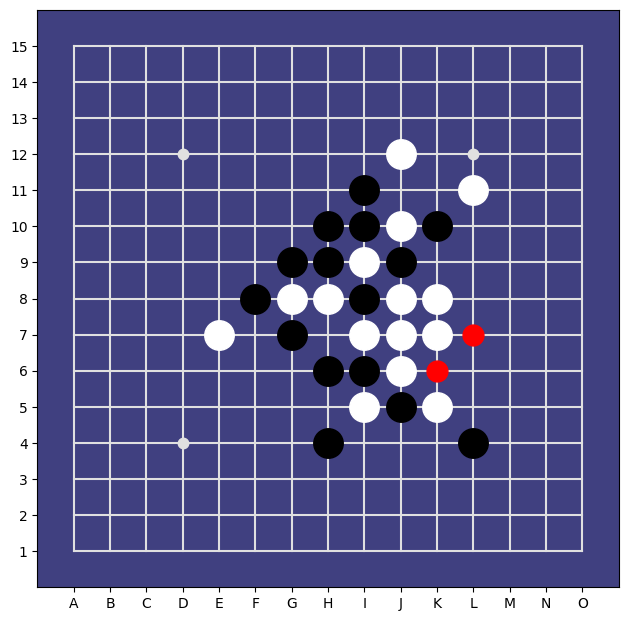

In [9]:
ds = curriculum[Focus.TERMINAL_OPPORTUNITY]['dataset']
s, p, v = next(iter(ds))
example = np.squeeze(s[0,:,:,:]), list(np.squeeze(p[0,:])), np.squeeze(v[0])
analyse_example(BOARD_SIZE, example, disp_width=7.5, policy_cutoff=.001)

## Terminal Threats

Next to play: WHITE
Value from WHITE's point of view: -0.9996071457862854


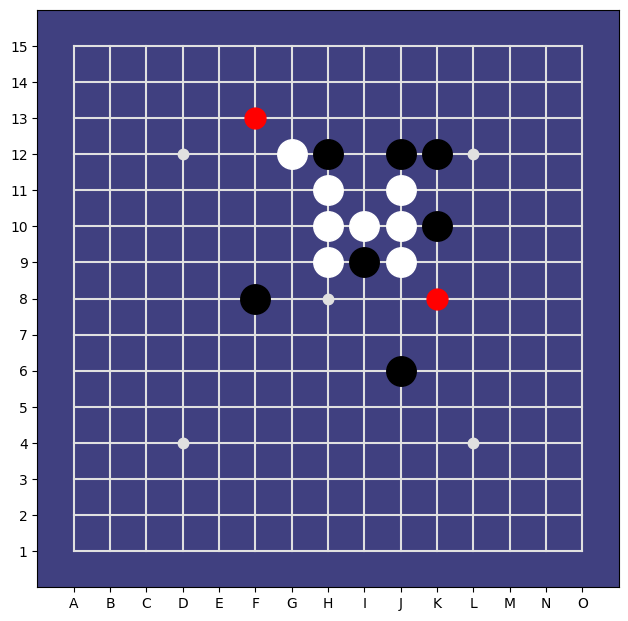

In [10]:
ds = curriculum[Focus.TERMINAL_THREAT]['dataset']
s, p, v = next(iter(ds))
example = np.squeeze(s[0,:,:,:]), list(np.squeeze(p[0,:])), np.squeeze(v[0])
analyse_example(BOARD_SIZE, example, disp_width=7.5, policy_cutoff=.001)

## Endgame

Next to play: BLACK
Value from BLACK's point of view: -0.887534499168396


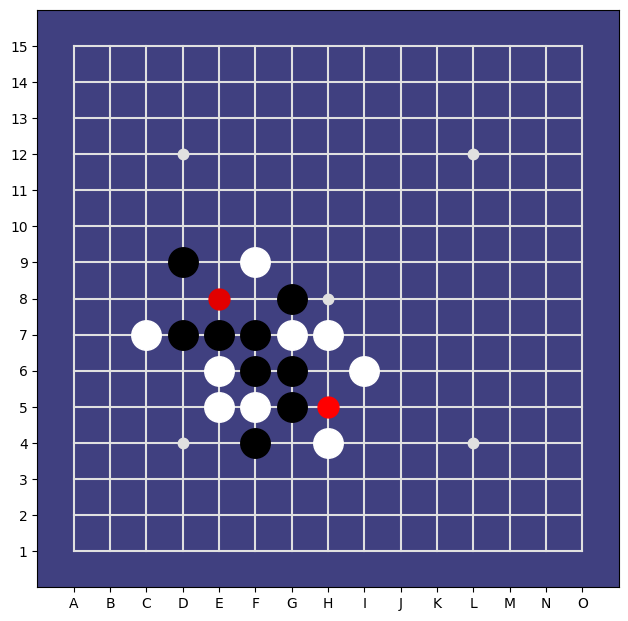

In [15]:
ds = curriculum[Focus.ENDGAME]['dataset']
s, p, v = next(iter(ds))
example = np.squeeze(s[0,:,:,:]), list(np.squeeze(p[0,:])), np.squeeze(v[0])
analyse_example(BOARD_SIZE, example, disp_width=7.5, policy_cutoff=.001)

## General Gameplay

Next to play: WHITE
Value from WHITE's point of view: -0.9152462482452393


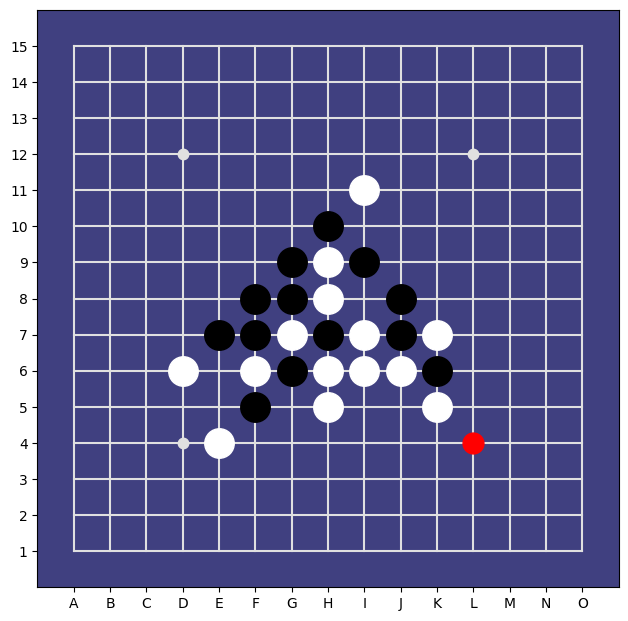

In [10]:
ds = curriculum[Focus.ALL_GAMEPLAY]['dataset']
s, p, v = next(iter(ds))
example = np.squeeze(s[0,:,:,:]), list(np.squeeze(p[0,:])), np.squeeze(v[0])
analyse_example(BOARD_SIZE, example, disp_width=7.5, policy_cutoff=.001)

In [11]:
from aegomoku.utils import stones_from_example
stones, winner = stones_from_example(example)
from aegomoku.gomoku_board import GomokuBoard
board = GomokuBoard(15, stones)
board.plot()
from aegomoku.gomoku_game import GomokuGame
game = GomokuGame(15)
game.get_winner(board) or "No winner yet."

                                                     
15    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
14    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
13    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
12    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
11    .  .  .  .  .  .  .  . [X] .  .  .  .  .  .    
10    .  .  .  .  .  .  .  O  .  .  .  .  .  .  .    
 9    .  .  .  .  .  .  O  X  O  .  .  .  .  .  .    
 8    .  .  .  .  .  O  O  X  .  O  .  .  .  .  .    
 7    .  .  .  .  O  O  X  O  X  O  X  .  .  .  .    
 6    .  .  .  X  .  X  O  X  X  X  O  .  .  .  .    
 5    .  .  .  .  .  O  .  X  .  .  X  .  .  .  .    
 4    .  .  .  .  X  .  .  .  .  .  .  .  .  .  .    
 3    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 2    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 1    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
                                                     
      A  B  C  D  E  F  G  H  I  J  K  L  M  N  O


/Users/wgiersche/.local/share/virtualenvs/DeepGomoku-cXtJ_EtM/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


'No winner yet.'

---

In [12]:
from aegomoku.gomoku_resnet import GomokuResnet

model = GomokuResnet(BOARD_SIZE, num_sensor_filters=128, num_blocks=4)
model.compile()
model.summary()

Model: "gomoku_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 17, 17, 3)]  0           []                               
                                                                                                  
 heuristic_detector (Conv2D)    (None, 17, 17, 307)  111748      ['inputs[0][0]']                 
                                                                                                  
 expand_1_11x11 (Conv2D)        (None, 17, 17, 128)  46592       ['inputs[0][0]']                 
                                                                                                  
 heuristic_priority (Conv2D)    (None, 17, 17, 5)    1540        ['heuristic_detector[0][0]']     
                                                                                      

In [13]:
trainer = Trainer(model)


## 1.  Warm up: Avoid Frustration
We use a first curriculum of smaller datasets to initiate the fresh network

In [17]:
ds = curriculum[Focus.ENDGAME]['dataset']
trainer.train(ds, epochs_per_train=10, report_every=1, v_weight=1.0)

Epoch: 1, Training: p: 5.373364, v: 0.7047332 - elapsed: 76.751s
Epoch: 2, Training: p: 5.373487, v: 0.701011 - elapsed: 37.308s
Epoch: 3, Training: p: 5.373521, v: 0.6972485 - elapsed: 40.196s
Epoch: 4, Training: p: 5.373443, v: 0.6933641 - elapsed: 41.792s
Epoch: 5, Training: p: 5.37338, v: 0.689425 - elapsed: 38.179s
Epoch: 6, Training: p: 5.373328, v: 0.6855194 - elapsed: 37.173s



KeyboardInterrupt



In [19]:
filenames = ["trajectories/mcts/the_heuristic_200.pickle",
             "trajectories/policy/terminal_opportunities.pickle",
             "trajectories/policy/terminal_threats.pickle"]

# Number of training samples from each course
N_warmup = [1000, 1000, 1000]
N_main = [20000, 2000, 4000]

curriculum = [read_training_data(filename, BOARD_SIZE) for filename in filenames]
datasets_warmup = []
datasets_main = []
for i in range(len(filenames)):
    examples = curriculum[i]
    datasets_warmup.append(create_dataset(examples[:N_warmup[i]]))
    datasets_main.append(create_dataset(examples[:N_main[i]]))

for i, course in enumerate(curriculum):
    print(filenames[i])
    print(len(course), len(course[0]), course[0][0].shape)

[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    1.414 1.414 1.414 1.414 0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    1.414 2.646 2.236 2.646 2.236 1.414
 0.    0.    0.    0.    0.    0.    1.414 1.414 0.    0.    2.236 3.162
 3.162 2.646 1.414 0.    0.    0.    0.    0.    0.    1.414 2.646 0.
 1.414 0.    2.236 0.    2.646 2.236 0.    0.    0.    0.    0.    0.
 2.236 2.646 3.162 2.236 0.    1.414 2.236 2.646 1.414 0.    0.    0.
 0.    0.    0.    1.414 2.646 3.162 0.    2.236 0.    1.414 1.414 0.
 0.    0.    0.    0.    0.    0.    1.414 2.646 3.162 2.646 2.646 0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    2.236 2.236
 2.236 2.236 1.414 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.  

KeyboardInterrupt: 

## A quick peek into the course material

trajectories/mcts/the_heuristic_200.pickle
Next to play: WHITE
Value from WHITE's point of view: -0.07604260914878462
trajectories/policy/terminal_opportunities.pickle
Next to play: BLACK
Value from BLACK's point of view: 0.9288062201386487
trajectories/policy/terminal_threats.pickle
Next to play: WHITE
Value from WHITE's point of view: -0.7951092100023196


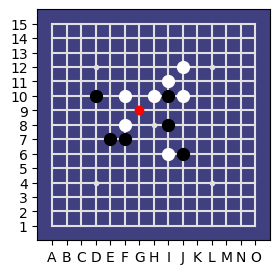

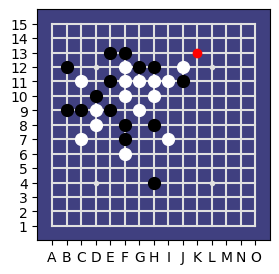

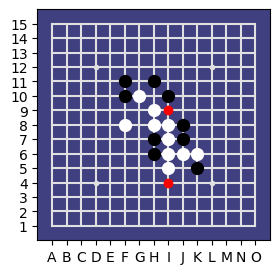

In [14]:
for i, course in enumerate(curriculum):
    print(filenames[i])
    analyse_example(BOARD_SIZE, course[random.randint(0, len(course))], disp_width=3)

---

# Construct a fresh model

In [97]:
from aegomoku.gomoku_resnet import GomokuResnet

model = GomokuResnet(BOARD_SIZE, num_sensor_filters=128, num_blocks=4)
model.compile()
model.summary()

Model: "gomoku_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 17, 17, 3)]  0           []                               
                                                                                                  
 heuristic_detector (Conv2D)    (None, 17, 17, 307)  111748      ['inputs[0][0]']                 
                                                                                                  
 expand_1_11x11 (Conv2D)        (None, 17, 17, 128)  46592       ['inputs[0][0]']                 
                                                                                                  
 heuristic_priority (Conv2D)    (None, 17, 17, 5)    1540        ['heuristic_detector[0][0]']     
                                                                                      

---


# Execute the curriculum
The idea here is to first teach the aspects of recognizing near-terminals in both directions: opportunities and threats.

Then mixing any other game position into the trainings to see the network improve on all subjects.

In [98]:
trainer = Trainer(model)


## 1.  Warm up: Avoid Frustration
We use a first curriculum of smaller datasets to initiate the fresh network

In [17]:
# Step one: understand almost-terminal positions
for i in range(10):
    print(f"Day {i+1}:")
    for ds in datasets_warmup[1:]:
        trainer.train(ds, epochs_per_train=10, report_every=None)

Day 1:


2022-08-28 15:39:49.663823: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-08-28 15:39:49.910978: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


Epoch: 10, Training: (5.984689, 0.42564225)
Epoch: 10, Training: (4.93517, 1.6454499)
Day 2:
Epoch: 10, Training: (5.099399, 0.7660154)
Epoch: 10, Training: (5.1135254, 0.42240945)
Day 3:
Epoch: 10, Training: (5.095559, 0.7811626)
Epoch: 10, Training: (5.087858, 0.43281984)
Day 4:
Epoch: 10, Training: (5.063113, 0.7571993)
Epoch: 10, Training: (5.034372, 0.45303822)
Day 5:
Epoch: 10, Training: (4.9373207, 0.7252458)
Epoch: 10, Training: (4.802661, 0.49764395)
Day 6:
Epoch: 10, Training: (4.87271, 0.7239165)
Epoch: 10, Training: (4.6543207, 0.46893826)
Day 7:
Epoch: 10, Training: (4.3898616, 0.61984456)
Epoch: 10, Training: (4.331273, 0.8262342)
Day 8:
Epoch: 10, Training: (4.746413, 0.76040953)
Epoch: 10, Training: (4.534007, 0.4296605)
Day 9:
Epoch: 10, Training: (3.9880328, 0.7305903)
Epoch: 10, Training: (3.3189864, 0.50517625)
Day 10:
Epoch: 10, Training: (3.3612587, 0.7467879)
Epoch: 10, Training: (2.433451, 0.4450102)


In [19]:
# Step 2: mix in all other positions
for i in range(10):
    print(f"Day {i+1}:")
    for ds in datasets_warmup:
        trainer.train(ds, epochs_per_train=20, report_every=20)

Day 1:
Epoch: 20, Training: (2.9545174, 0.37637115)
Epoch: 20, Training: (2.2783313, 0.6314651)
Epoch: 20, Training: (1.5957326, 0.5706433)
Day 2:
Epoch: 20, Training: (2.583715, 0.37852105)
Epoch: 20, Training: (2.064467, 0.5933886)
Epoch: 20, Training: (1.4782984, 0.5794381)
Day 3:
Epoch: 20, Training: (2.5468936, 0.38018087)
Epoch: 20, Training: (1.8841041, 0.5721065)
Epoch: 20, Training: (1.4671216, 0.5783595)
Day 4:
Epoch: 20, Training: (2.5332785, 0.37902275)
Epoch: 20, Training: (1.8168484, 0.5695618)
Epoch: 20, Training: (1.3424422, 0.58094114)
Day 5:
Epoch: 20, Training: (2.4570355, 0.37900242)
Epoch: 20, Training: (1.6790651, 0.5693162)
Epoch: 20, Training: (1.270053, 0.5763603)
Day 6:
Epoch: 20, Training: (2.4121413, 0.37815952)
Epoch: 20, Training: (1.5680506, 0.5703819)
Epoch: 20, Training: (1.2108147, 0.57305735)
Day 7:
Epoch: 20, Training: (2.388958, 0.37695324)
Epoch: 20, Training: (1.4582207, 0.572131)
Epoch: 20, Training: (1.140311, 0.5720842)
Day 8:
Epoch: 20, Traini

---

In [22]:
## The full training

In [24]:
for i in range(5):
    print(f"Day {i+1}:")
    for ds in datasets_main:
        trainer.train(ds, epochs_per_train=20, report_every=None)

Day 1:
Epoch: 20, Training: (1.9103442, 0.14034212)
Epoch: 20, Training: (0.44540924, 0.48245272)
Epoch: 20, Training: (0.78295135, 0.13109705)
Day 2:
Epoch: 20, Training: (1.8499267, 0.088037685)
Epoch: 20, Training: (0.4131093, 0.0917298)
Epoch: 20, Training: (0.82444936, 0.20029807)
Day 3:
Epoch: 20, Training: (1.9201267, 0.08883932)
Epoch: 20, Training: (0.7045783, 0.09379841)
Epoch: 20, Training: (0.8149947, 0.13776222)
Day 4:
Epoch: 20, Training: (1.9129205, 0.085171014)
Epoch: 20, Training: (0.4212504, 0.0651084)
Epoch: 20, Training: (0.81880075, 0.27886462)
Day 5:
Epoch: 20, Training: (1.9625417, 0.088207014)
Epoch: 20, Training: (0.424814, 0.11423471)
Epoch: 20, Training: (0.84872854, 0.88825333)


---

# Performance on formerly unseen data

n=36011
Next to play: BLACK
Value from BLACK's point of view: 0.799886155502954
Next to play: BLACK
Value from BLACK's point of view: -0.408933162689209


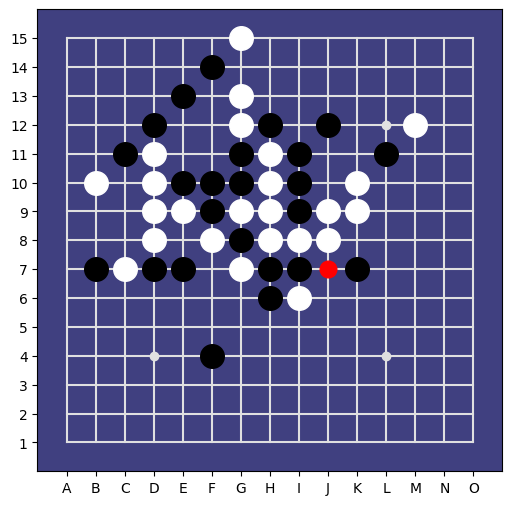

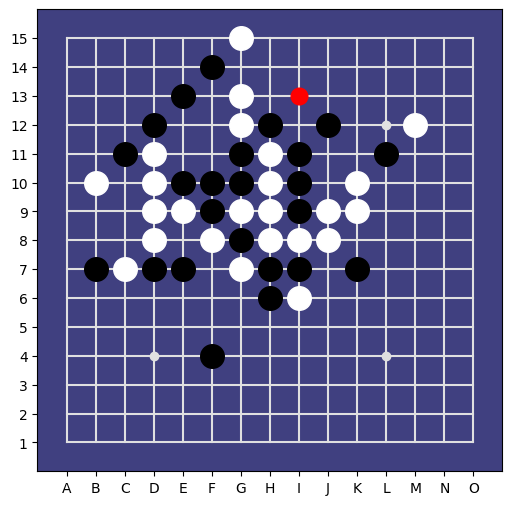

In [30]:
from aegomoku.utils import analyse_example
training_data = curriculum[0]

n = random.randint(N_main[0], len(training_data))
sample = np.expand_dims(training_data[n][0], axis=0).astype(float)

# Training Material
print(f"n={n}")
analyse_example(BOARD_SIZE, training_data[n])

# Learned
s, p, v = training_data[n]
p_learned, v_learned = model(sample)
learned = (s, list(p_learned.numpy()), np.squeeze(v_learned))
analyse_example(BOARD_SIZE, learned)